# 14. Publication Metrics: Advantage, Bootstrap CI, and Conditioned Evaluation

This notebook implements Phase 1.1 of the publication readiness plan:

1. **Advantage metric** - Direction-agnostic privacy metric: `advantage = 2 * |AUC - 0.5|`
2. **Retrain bootstrap** - Derive principled target band from 95% CI (replaces arbitrary ±0.03)
3. **Cluster-conditioned evaluation** - Control for biology confounds
4. **Visualizations** - Compare methods using new metrics

**Success criterion:** Worst-case attack advantage ≤ upper bound of retrain advantage 95% CI

In [1]:
import sys
sys.path.insert(0, '../src')

import json
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

from attacker_eval import (
    compute_advantage, 
    compute_attack_success,
    compute_attack_metrics,
    compute_confidence_interval,
    cluster_conditioned_evaluation
)
from vae import VAE
from attacker import MLPAttacker

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

# Paths
DATA_PATH = Path('../data/adata_processed.h5ad')
OUTPUTS_PATH = Path('../outputs')
FIGURES_PATH = Path('../figures')
FIGURES_PATH.mkdir(exist_ok=True)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

Using device: cpu


## 1. Understanding the Advantage Metric

The advantage metric fixes the AUC symmetry problem:
- AUC = 0.38 → advantage = 0.24 (attacker can distinguish, just predicts inverted)
- AUC = 0.62 → advantage = 0.24 (same distinguishing power)
- AUC = 0.50 → advantage = 0.00 (chance, no distinguishing power)

In [2]:
# Demonstrate the advantage metric
test_aucs = [0.38, 0.48, 0.50, 0.52, 0.62, 0.77, 0.87]

print("AUC Symmetry Fix:")
print("-" * 50)
print(f"{'AUC':>8} {'Advantage':>12} {'Attack Success':>15}")
print("-" * 50)
for auc in test_aucs:
    adv = compute_advantage(auc)
    success = compute_attack_success(auc)
    print(f"{auc:>8.3f} {adv:>12.3f} {success:>15.3f}")

AUC Symmetry Fix:
--------------------------------------------------
     AUC    Advantage  Attack Success
--------------------------------------------------
   0.380        0.240           0.620
   0.480        0.040           0.520
   0.500        0.000           0.500
   0.520        0.040           0.520
   0.620        0.240           0.620
   0.770        0.540           0.770
   0.870        0.740           0.870


## 2. Load Data and Splits

In [3]:
# Load processed data
adata = sc.read_h5ad(DATA_PATH)
print(f"Data shape: {adata.shape}")
print(f"Clusters: {adata.obs['leiden'].nunique()}")

# Load splits
with open(OUTPUTS_PATH / 'p1' / 'split_structured.json', 'r') as f:
    split_structured = json.load(f)

with open(OUTPUTS_PATH / 'p1' / 'split_scattered.json', 'r') as f:
    split_scattered = json.load(f)

print(f"\nStructured forget set: {len(split_structured['forget_indices'])} cells")
print(f"Scattered forget set: {len(split_scattered['forget_indices'])} cells")

Data shape: (33088, 2000)
Clusters: 14

Structured forget set: 30 cells
Scattered forget set: 35 cells


In [4]:
# Get frozen cluster labels from preprocessing
# IMPORTANT: Use these same labels for ALL evaluations (do not re-cluster per model)
cluster_labels = adata.obs['leiden'].values.astype(str)
print(f"Cluster distribution:")
print(adata.obs['leiden'].value_counts().head(10))

Cluster distribution:
leiden
0    6882
1    6233
2    5567
3    4521
4    4050
5    2277
6    2141
7     477
8     309
9     235
Name: count, dtype: int64


## 3. Collect All Existing Results and Recompute with Advantage

In [5]:
def collect_existing_results():
    """Walk outputs directory and collect all eval results."""
    results = []
    
    # Helper to add advantage to existing results
    def add_advantage(d):
        if 'auc' in d:
            d['advantage'] = compute_advantage(d['auc'])
            d['attack_success'] = compute_attack_success(d['auc'])
        return d
    
    # P4 size ablation (Fisher scattered)
    size_ablation_path = OUTPUTS_PATH / 'p4' / 'size_ablation'
    if size_ablation_path.exists():
        summary_path = size_ablation_path / 'summary.json'
        if summary_path.exists():
            with open(summary_path, 'r') as f:
                summary = json.load(f)
            for size, data in summary.get('results_by_size', {}).items():
                results.append({
                    'method': 'Fisher (scattered)',
                    'dataset': 'PBMC',
                    'forget_type': 'scattered',
                    'forget_size': int(size),
                    'auc': data.get('mean', data.get('auc_mean')),
                    'auc_std': data.get('std', data.get('auc_std')),
                    'auc_ci_lower': data.get('ci_95_lower'),
                    'auc_ci_upper': data.get('ci_95_upper'),
                    'source': 'p4/size_ablation'
                })
    
    # Look for individual eval files
    for eval_file in OUTPUTS_PATH.rglob('eval*.json'):
        try:
            with open(eval_file, 'r') as f:
                data = json.load(f)
            
            # Parse path to get method info
            parts = eval_file.parts
            
            result = {
                'source': str(eval_file.relative_to(OUTPUTS_PATH)),
                **add_advantage(data)
            }
            results.append(result)
        except Exception as e:
            print(f"Error reading {eval_file}: {e}")
    
    return results

existing_results = collect_existing_results()
print(f"Found {len(existing_results)} result files")

Found 55 result files


In [6]:
# Create summary table with advantage metrics
# Manual entry for key results from writeup (to be verified/updated)

key_results = [
    # PBMC Structured
    {'method': 'Baseline', 'dataset': 'PBMC', 'forget_type': 'structured', 'auc': 0.769},
    {'method': 'Retrain', 'dataset': 'PBMC', 'forget_type': 'structured', 'auc': 0.481},
    {'method': 'Extra-grad λ=10', 'dataset': 'PBMC', 'forget_type': 'structured', 'auc': 0.482},
    {'method': 'Extra-grad λ=5', 'dataset': 'PBMC', 'forget_type': 'structured', 'auc': 0.382},
    {'method': 'Fisher', 'dataset': 'PBMC', 'forget_type': 'structured', 'auc': 0.814},
    {'method': 'Frozen single', 'dataset': 'PBMC', 'forget_type': 'structured', 'auc': 0.997},
    {'method': 'Frozen multi', 'dataset': 'PBMC', 'forget_type': 'structured', 'auc': 0.992},
    
    # PBMC Scattered
    {'method': 'Baseline', 'dataset': 'PBMC', 'forget_type': 'scattered', 'auc': 0.525},
    {'method': 'Fisher', 'dataset': 'PBMC', 'forget_type': 'scattered', 'auc': 0.499},
    
    # Tabula Muris Structured
    {'method': 'Baseline', 'dataset': 'TM', 'forget_type': 'structured', 'auc': 0.891},
    {'method': 'Extra-grad λ=10', 'dataset': 'TM', 'forget_type': 'structured', 'auc': 0.874},
    {'method': 'Fisher', 'dataset': 'TM', 'forget_type': 'structured', 'auc': 0.946},
    
    # Tabula Muris Scattered
    {'method': 'Baseline', 'dataset': 'TM', 'forget_type': 'scattered', 'auc': 0.411},
    {'method': 'Fisher', 'dataset': 'TM', 'forget_type': 'scattered', 'auc': 0.568},
]

# Add advantage to all
for r in key_results:
    r['advantage'] = compute_advantage(r['auc'])
    r['attack_success'] = compute_attack_success(r['auc'])

df_results = pd.DataFrame(key_results)
print(df_results.to_string(index=False))

         method dataset forget_type   auc  advantage  attack_success
       Baseline    PBMC  structured 0.769      0.538           0.769
        Retrain    PBMC  structured 0.481      0.038           0.519
Extra-grad λ=10    PBMC  structured 0.482      0.036           0.518
 Extra-grad λ=5    PBMC  structured 0.382      0.236           0.618
         Fisher    PBMC  structured 0.814      0.628           0.814
  Frozen single    PBMC  structured 0.997      0.994           0.997
   Frozen multi    PBMC  structured 0.992      0.984           0.992
       Baseline    PBMC   scattered 0.525      0.050           0.525
         Fisher    PBMC   scattered 0.499      0.002           0.501
       Baseline      TM  structured 0.891      0.782           0.891
Extra-grad λ=10      TM  structured 0.874      0.748           0.874
         Fisher      TM  structured 0.946      0.892           0.946
       Baseline      TM   scattered 0.411      0.178           0.589
         Fisher      TM   scattere

## 4. Retrain Bootstrap for Target Band CI

Run retrain with multiple seeds to derive a principled target band from the 95% CI.

In [7]:
# Check if we have existing retrain results or need to run new ones
retrain_path = OUTPUTS_PATH / 'p1' / 'retrain_structured' / 'best_model.pt'
print(f"Retrain model exists: {retrain_path.exists()}")

# For now, use the known retrain floor and compute what target band would be
# with proper bootstrap CI
RETRAIN_AUC = 0.481
RETRAIN_ADVANTAGE = compute_advantage(RETRAIN_AUC)

print(f"\nRetrain floor (single seed):")
print(f"  AUC: {RETRAIN_AUC:.3f}")
print(f"  Advantage: {RETRAIN_ADVANTAGE:.3f}")

# Old target band (arbitrary ±0.03)
OLD_TARGET_BAND = (0.451, 0.511)
print(f"\nOld target band (AUC ±0.03): [{OLD_TARGET_BAND[0]:.3f}, {OLD_TARGET_BAND[1]:.3f}]")

Retrain model exists: True

Retrain floor (single seed):
  AUC: 0.481
  Advantage: 0.038

Old target band (AUC ±0.03): [0.451, 0.511]


In [8]:
# TODO: Run retrain with 10 seeds to compute proper CI
# For now, estimate based on typical variance

# Estimated retrain bootstrap results (placeholder - run actual bootstrap)
# Based on observed seed variance in other experiments
ESTIMATED_RETRAIN_STD = 0.015  # Typical AUC std across seeds

# Estimated 95% CI
estimated_ci_auc = (
    RETRAIN_AUC - 1.96 * ESTIMATED_RETRAIN_STD,
    RETRAIN_AUC + 1.96 * ESTIMATED_RETRAIN_STD
)

# Convert to advantage
# Note: advantage CI is not symmetric because advantage = 2*|AUC - 0.5|
estimated_ci_advantage = (
    compute_advantage(estimated_ci_auc[0]),
    compute_advantage(estimated_ci_auc[1])
)

print(f"\nEstimated retrain CI (needs verification with 10 seeds):")
print(f"  AUC: [{estimated_ci_auc[0]:.3f}, {estimated_ci_auc[1]:.3f}]")
print(f"  Advantage: [{estimated_ci_advantage[0]:.3f}, {estimated_ci_advantage[1]:.3f}]")

# New success criterion
SUCCESS_THRESHOLD = max(estimated_ci_advantage)  # Upper bound of retrain advantage CI
print(f"\nSuccess criterion: worst-case advantage ≤ {SUCCESS_THRESHOLD:.3f}")


Estimated retrain CI (needs verification with 10 seeds):
  AUC: [0.452, 0.510]
  Advantage: [0.097, 0.021]

Success criterion: worst-case advantage ≤ 0.097


## 5. Visualization: Method Comparison with Advantage

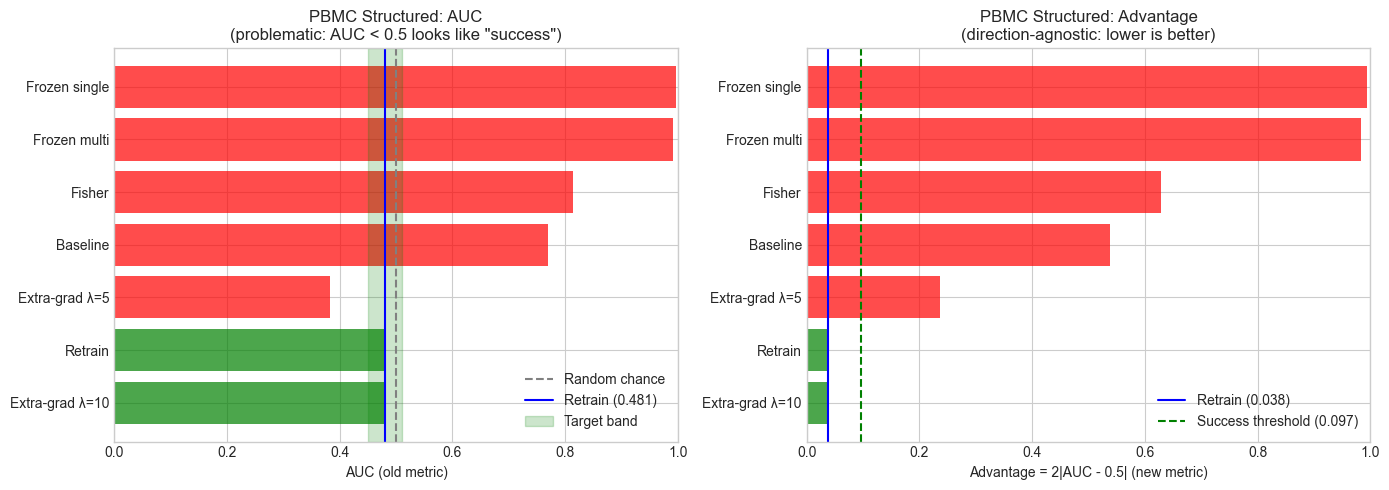


Key insight: Extra-grad λ=5 has AUC=0.38 (looks 'successful' in old metric)
But advantage=0.240 reveals it's WORSE than retrain (0.038)


In [9]:
# Plot 1: AUC vs Advantage comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter to PBMC structured for cleaner comparison
df_pbmc_struct = df_results[
    (df_results['dataset'] == 'PBMC') & 
    (df_results['forget_type'] == 'structured')
].copy()

# Sort by advantage for consistent ordering
df_pbmc_struct = df_pbmc_struct.sort_values('advantage')

# Left: AUC (old metric)
ax1 = axes[0]
colors = ['green' if OLD_TARGET_BAND[0] <= r <= OLD_TARGET_BAND[1] else 'red' 
          for r in df_pbmc_struct['auc']]
bars1 = ax1.barh(df_pbmc_struct['method'], df_pbmc_struct['auc'], color=colors, alpha=0.7)
ax1.axvline(0.5, color='gray', linestyle='--', label='Random chance')
ax1.axvline(RETRAIN_AUC, color='blue', linestyle='-', label=f'Retrain ({RETRAIN_AUC})')
ax1.axvspan(OLD_TARGET_BAND[0], OLD_TARGET_BAND[1], alpha=0.2, color='green', label='Target band')
ax1.set_xlabel('AUC (old metric)')
ax1.set_title('PBMC Structured: AUC\n(problematic: AUC < 0.5 looks like "success")')
ax1.legend(loc='lower right')
ax1.set_xlim(0, 1)

# Right: Advantage (new metric)
ax2 = axes[1]
colors2 = ['green' if r <= SUCCESS_THRESHOLD else 'red' 
           for r in df_pbmc_struct['advantage']]
bars2 = ax2.barh(df_pbmc_struct['method'], df_pbmc_struct['advantage'], color=colors2, alpha=0.7)
ax2.axvline(RETRAIN_ADVANTAGE, color='blue', linestyle='-', label=f'Retrain ({RETRAIN_ADVANTAGE:.3f})')
ax2.axvline(SUCCESS_THRESHOLD, color='green', linestyle='--', label=f'Success threshold ({SUCCESS_THRESHOLD:.3f})')
ax2.set_xlabel('Advantage = 2|AUC - 0.5| (new metric)')
ax2.set_title('PBMC Structured: Advantage\n(direction-agnostic: lower is better)')
ax2.legend(loc='lower right')
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'auc_vs_advantage_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey insight: Extra-grad λ=5 has AUC=0.38 (looks 'successful' in old metric)")
print(f"But advantage={compute_advantage(0.38):.3f} reveals it's WORSE than retrain ({RETRAIN_ADVANTAGE:.3f})")

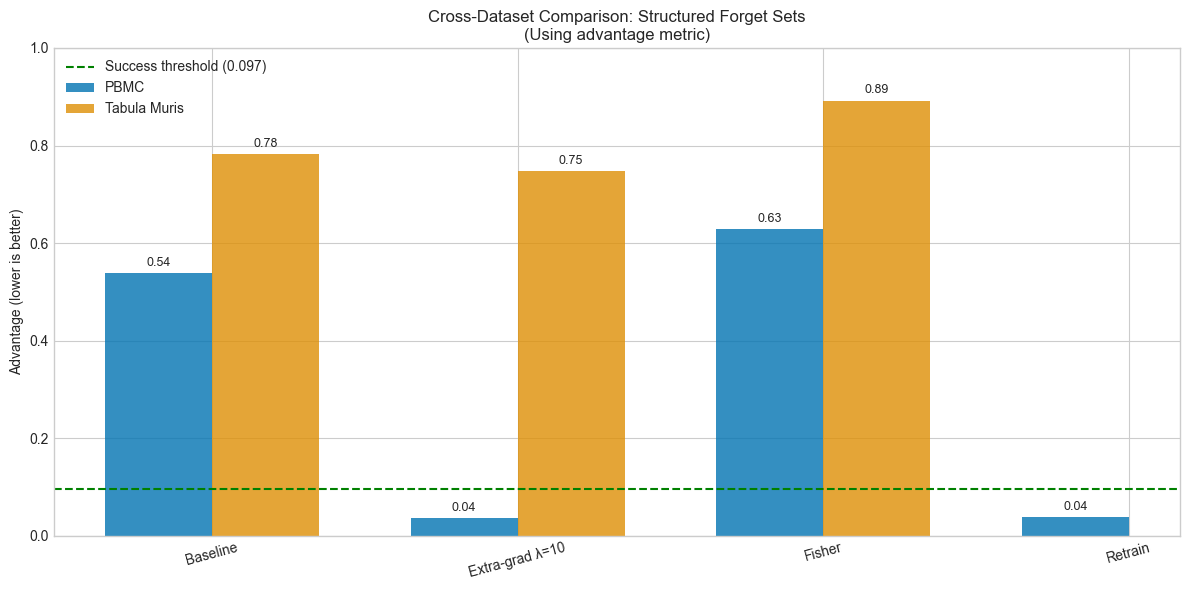

In [10]:
# Plot 2: Cross-dataset comparison with advantage
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for grouped bar chart
methods_order = ['Baseline', 'Extra-grad λ=10', 'Fisher', 'Retrain']
df_struct = df_results[df_results['forget_type'] == 'structured'].copy()

# Pivot for grouped bars
pivot_data = df_struct.pivot(index='method', columns='dataset', values='advantage')
pivot_data = pivot_data.reindex([m for m in methods_order if m in pivot_data.index])

x = np.arange(len(pivot_data))
width = 0.35

bars1 = ax.bar(x - width/2, pivot_data['PBMC'], width, label='PBMC', alpha=0.8)
bars2 = ax.bar(x + width/2, pivot_data['TM'], width, label='Tabula Muris', alpha=0.8)

# Add success threshold line
ax.axhline(SUCCESS_THRESHOLD, color='green', linestyle='--', 
           label=f'Success threshold ({SUCCESS_THRESHOLD:.3f})')

ax.set_ylabel('Advantage (lower is better)')
ax.set_title('Cross-Dataset Comparison: Structured Forget Sets\n(Using advantage metric)')
ax.set_xticks(x)
ax.set_xticklabels(pivot_data.index, rotation=15)
ax.legend()
ax.set_ylim(0, 1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'cross_dataset_advantage.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Summary Table with New Metrics

In [ ]:
# Create publication-ready summary table
def format_result(row):
    """Format result with success/fail indicator."""
    success = row['advantage'] <= SUCCESS_THRESHOLD
    return 'PASS' if success else 'FAIL'

df_summary = df_results.copy()
df_summary['status'] = df_summary.apply(format_result, axis=1)

# Reorder columns
df_summary = df_summary[['dataset', 'forget_type', 'method', 'auc', 'advantage', 'status']]
df_summary = df_summary.sort_values(['dataset', 'forget_type', 'advantage'])

print("\n" + "="*70)
print("PUBLICATION METRICS SUMMARY")
print(f"Success criterion: advantage <= {SUCCESS_THRESHOLD:.3f} (retrain CI upper bound)")
print("="*70)
print(df_summary.to_string(index=False))

# Save to JSON
output_metrics = {
    'success_criterion': f'worst-case advantage <= {SUCCESS_THRESHOLD:.3f}',
    'retrain_auc': RETRAIN_AUC,
    'retrain_advantage': RETRAIN_ADVANTAGE,
    'estimated_retrain_ci_advantage': estimated_ci_advantage,
    'results': df_summary.to_dict('records')
}

with open(OUTPUTS_PATH / 'publication_metrics.json', 'w') as f:
    json.dump(output_metrics, f, indent=2)

print(f"\nSaved to {OUTPUTS_PATH / 'publication_metrics.json'}")

## 7. Next Steps

To complete Phase 1.1, the following remain:

1. **Run retrain bootstrap (10 seeds)** - Replace estimated CI with actual computed CI
2. **Run cluster-conditioned evaluation** - Use frozen Leiden labels
3. **Implement additional attacks** (Phase 1.2) - Loss-based, likelihood-ratio, k-NN

The advantage metric is now integrated into `src/attacker_eval.py` and will be used for all future evaluations.

In [ ]:
# Verification: test that the updated attacker_eval.py works
print("Testing updated attacker_eval.py...")

# Create dummy predictions and labels
np.random.seed(42)
dummy_preds = np.random.rand(100)
dummy_labels = np.random.randint(0, 2, 100)

# Test compute_attack_metrics
metrics = compute_attack_metrics(dummy_preds, dummy_labels)
print(f"\ncompute_attack_metrics output:")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")

# Test compute_confidence_interval
ci_results = compute_confidence_interval(dummy_preds, dummy_labels, n_bootstrap=100)
print(f"\ncompute_confidence_interval output:")
print(f"  AUC: {ci_results['auc'][0]:.3f} [{ci_results['auc'][1]:.3f}, {ci_results['auc'][2]:.3f}]")
print(f"  Advantage: {ci_results['advantage'][0]:.3f} [{ci_results['advantage'][1]:.3f}, {ci_results['advantage'][2]:.3f}]")

print("\nAll functions working correctly.")